In [6]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from catboost import CatBoostClassifier

In [7]:
import plotly.graph_objects as go

In [8]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from tqdm import tqdm

# Загружаем ранее посчитанные модели

In [9]:
with open('baseline.pickle', 'rb') as f:
    results = pickle.load(f)
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,Validation r2,Test R²,Test MAE,Test RMSE,Best Estimator
0,KNN,"{'regressor__n_neighbors': 7, 'regressor__p': ...",0.858822,0.861995,19.347841,28.108901,"(ColumnTransformer(transformers=[('num',\n ..."
1,ElasticNet,"{'regressor__alpha': 0.07, 'regressor__l1_rati...",0.911070,0.914270,16.065511,22.154541,"(ColumnTransformer(transformers=[('num',\n ..."
2,RandomForest,"{'regressor__max_depth': 23, 'regressor__n_est...",0.907528,0.905332,16.317320,23.280833,"(ColumnTransformer(transformers=[('num',\n ..."


In [10]:
with open('classification.pickle', 'rb') as f:
    classification_df = pickle.load(f)

In [11]:
with open('regression.pickle', 'rb') as f:
    models = pickle.load(f)

In [17]:
with open('x_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

In [18]:
with open('y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

### Используем модель, найденную классификацией

In [14]:
classification = 1
clf = classification_df["Best Estimator"][classification]
clf

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [15]:
import shap

In [19]:
background = shap.sample(X_train, 1000, random_state=0) if len(X_train) > 1000 else X_train


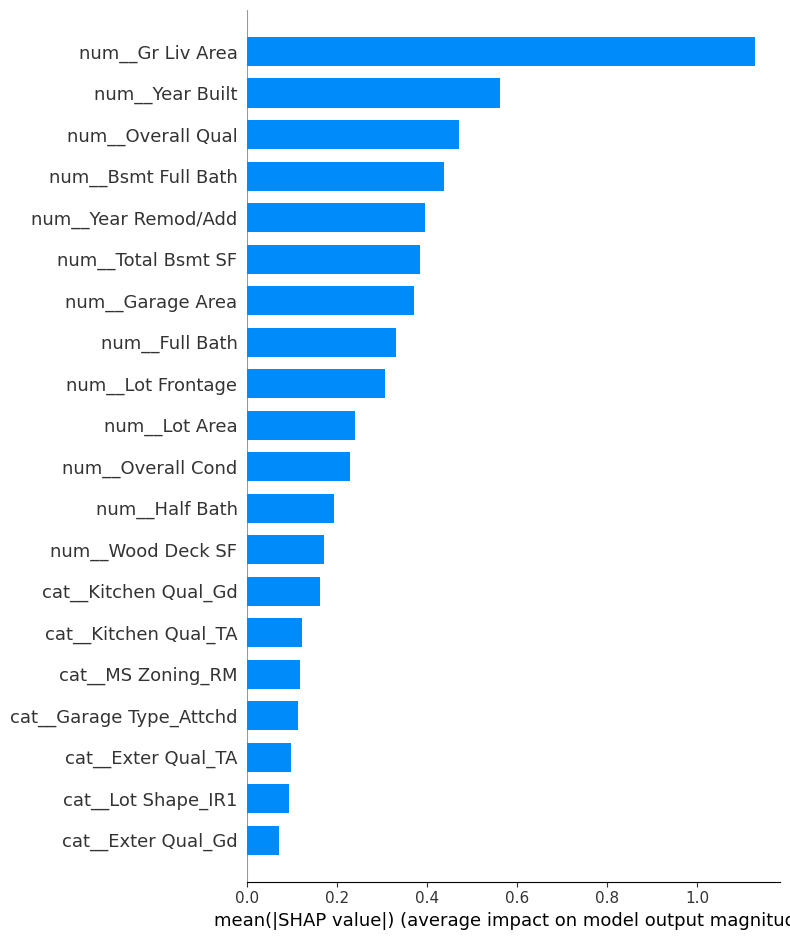

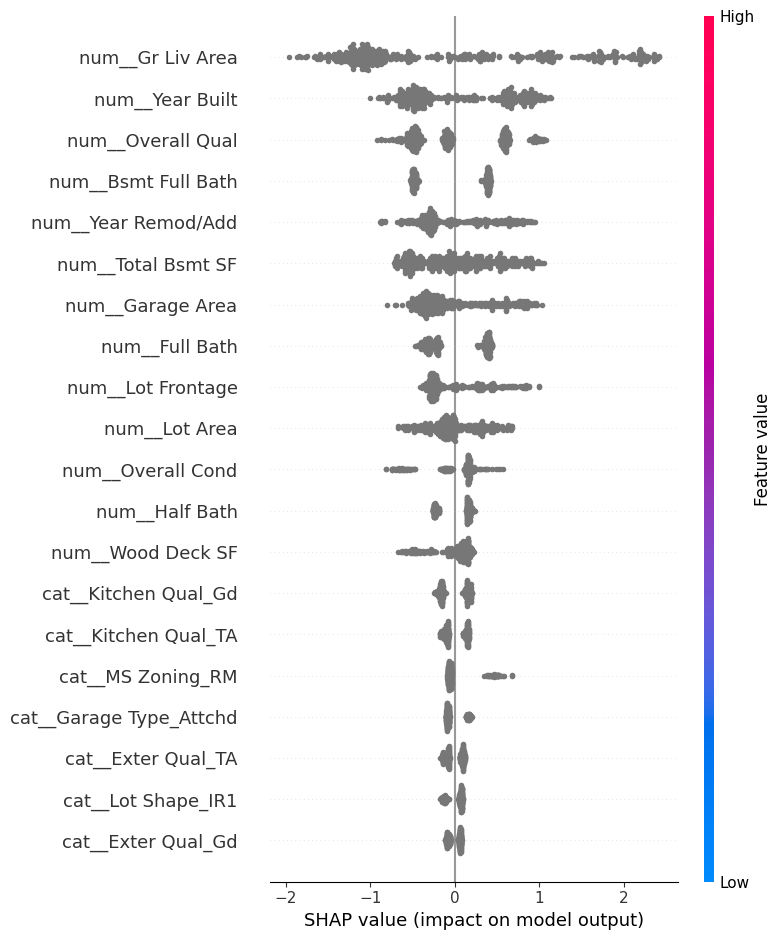

In [20]:
pipe = classification_df["Best Estimator"][classification]
preproc = pipe[:-1]          # все шаги до модели
clf = pipe[-1]               # сама модель 

# 1) Преобразуем валидацию так же, как на обучении
Xv_t = preproc.transform(X_test)

# 2) Имена фич после трансформации (если доступны)
try:
    feature_names = preproc.get_feature_names_out()
except Exception:
    # запасной вариант
    feature_names = getattr(X_val, "columns", [f"f{i}" for i in range(Xv_t.shape[1])])

# 3) Выбираем правильный объяснитель для деревьев
explainer = shap.TreeExplainer(clf, model_output="raw")
shap_values = explainer.shap_values(Xv_t)     # мультикласс → список/массив по классам

# 4) Быстрый барплот важности для класса 0 (замените на нужный)
k = 0
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[k], Xv_t, feature_names=feature_names, plot_type="bar")
else:
    shap.summary_plot(shap_values[..., k], Xv_t, feature_names=feature_names, plot_type="bar")

# 5) Обзорный beeswarm для того же класса
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[k], Xv_t, feature_names=feature_names)
else:
    shap.summary_plot(shap_values[..., k], Xv_t, feature_names=feature_names)